In [1]:
import pdftotext, re, pandas as pd
from glob import glob
from datetime import datetime

def parse_visa(f):
    with open(f, "rb") as fp:
        pdf = pdftotext.PDF(fp)

    result = ''
    for page in pdf:
        start = None
        end = None
        possible_starts = ('FECHA',)
        possible_ends = ('¿Quiere pagar', 'SALDO ACTUAL')
        for s in possible_starts:
            if s in page:
                i = page.index(s)
                if start is None or i > start:
                    start = i

        for e in possible_ends:
            if e in page:
                i = page.index(e)
                if end is None or i > end:
                    end = i

        if None not in (start, end):
            result += page[start:end]

    def parse_value(v):
        v = v.strip()
        if v.startswith('FECHA') or v.startswith('SALDO ANTERIOR'):
            return None
        # print(v)
        res = re.match(
            r'^([0-9]{2})\.([0-9]{2})\.([0-9]{2})\s+'
            r'(?:[0-9]{6}.?\s+)?'
            r'(.+?)\s+'
            r'(\s{1,}Cuota\s+\d{2}/\d{2}\s+)?'
            r'((?:USD|BRL|UYU)\s*[\d\,\.]+-?\s+)?'
            r'([\d\,\.]+-?)(?:\s*_)?$'
            , v)
        if res is None:
            # print(v)
            return None
        g = res.groups()
        n = float(g[6].replace('.', '').replace('-', '').replace(',', '.'))
        is_usd = g[5] is not None or g[3] == 'SU PAGO EN USD'
        n *= 1 if '-' in g[6] else -1
        return (datetime(2000 + int(g[2]), int(g[1]), int(g[0])), g[3], 0.0 if is_usd else n, 0.0 if not is_usd else n)

    values = [parse_value(v) for v in result.split('\n')]
    return pd.DataFrame([v for v in values if v is not None], columns=('date', 'description', 'ars', 'usd'))

    def dashrepl(matchobj):
        if matchobj.group(0) == '***,**': return ' '
        else: return '***,**'
    return re.sub(r'[0-9\.]+,[0-9]{2}', dashrepl, result)

df = pd.concat([parse_visa(x) for x in glob('data/resumen_cuenta_visa*.pdf')]).reset_index().drop(['index'], axis=1)
df['ars'] = df['ars'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df['usd'] = df['usd'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df

,date,description,ars,usd
0,2018-11-05,SU PAGO EN PESOS,***.**,0.00
1,2018-11-05,SU PAGO EN USD,0.00,***.**
2,2018-01-12,CLARO EQUIPOS,-***.**,0.00
3,2018-04-05,DISTRIBUIDORES INDEPEND PSA Cuota 08/12,-***.**,0.00
4,2018-05-06,DESPEGAR.COM,-***.**,0.00
5,2018-05-06,DESPEGAR.COM,-***.**,0.00
6,2018-05-06,DESPEGAR.COM,-***.**,0.00
7,2018-05-14,WWW.DESPEGAR.COM,-***.**,0.00
8,2018-08-30,WWW.JUMBOACASA.COM.AR/5231,-***.**,0.00
9,2018-09-06,WWW.JUMBOACASA.COM.AR/5231,-***.**,0.00


In [2]:
def parse_icbc(f):
    with open(f, "rb") as fp:
        pdf = pdftotext.PDF(fp)

    def strip_balance(line):
        return re.sub(r'([\d\.]+,\d{2}\-?)\s+[\d\.]+,\d{2}', r'\1', line)
    # This breaks cross-year, but it doesn't seem to happen
    year = int(re.search(r'PERIODO \d\d-\d\d-(\d{4})', pdf[0]).groups()[0])
    result = ''
    for pagenum, page in enumerate(pdf):
        start = None
        end = None
        possible_starts = ('FECHA',)
        possible_ends = ('CONTINUA', 'SALDO FINAL')
        for s in possible_starts:
            if s in page:
                i = page.index(s)
                if start is None or i > start:
                    start = i

        for e in possible_ends:
            if e in page:
                i = page.index(e)
                if end is None or i > end:
                    end = i

        if None not in (start, end):
            result += '\n'.join([strip_balance(x) for x in page[start:end].split('\n')])

    def parse_value(v):
        v = v.strip()
        if v.startswith('FECHA') or v.startswith('SALDO ANTERIOR'):
            return None
        # print(v)
        res = re.match(
            r'^([0-9]{2})-([0-9]{2})\s+'
            r'(?:[0-9]{6}.?)?\s*'
            r'(.+?)'
            r'([\d\.]+\,\d\d-?)(?:\s*_)?$'
            , v)
        if res is None:
            return None
        g = res.groups()
        n = float(g[3].replace('.', '').replace('-', '').replace(',', '.'))
        n *= -1 if '-' in g[3] else 1
        return (datetime(year, int(g[1]), int(g[0])), g[2], n, 0.0)

    values = [parse_value(v) for v in result.split('\n')]
    return pd.DataFrame([v for v in values if v is not None], columns=('date', 'description', 'ars', 'usd'))

    def dashrepl(matchobj):
        if matchobj.group(0) == '***,**': return ' '
        else: return '***,**'
    return re.sub(r'[0-9\.]+,[0-9]{2}', dashrepl, result)

df = pd.concat([parse_icbc(x) for x in glob('data/EXT.DE.MOVIMIENTOS*.pdf')]).reset_index().drop(['index'], axis=1)
df['ars'] = df['ars'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df['usd'] = df['usd'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df

,date,description,ars,usd
0,2018-04-03,CRED. CAPITAL POR PAGO DE IPF ...,***.**,0.00
1,2018-04-03,CREDITO INT. DE PLAZO FIJO ...,***.**,0.00
2,2018-04-03,CRED. CAPITAL POR PAGO DE IPF ...,***.**,0.00
3,2018-04-03,CREDITO INT. DE PLAZO FIJO ...,***.**,0.00
4,2018-04-03,PAGO EDESUR ...,-***.**,0.00
5,2018-04-03,PAGO GCBA INM/ABL ...,-***.**,0.00
6,2018-04-03,PAGO METROGAS ...,-***.**,0.00
7,2018-04-03,PAGO AYSA ...,-***.**,0.00
8,2018-04-03,TRANSF. ACC.B. ...,-***.**,0.00
9,2018-04-03,TRANS PAG SUEL ...,***.**,0.00


In [3]:
def parse_movs(f):
    df = pd.read_csv(f, header=None, names=('date', 'description', 'debit', 'credit', 'garbage'))
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
    df['ars'] = df['credit'] - df['debit']
    df.drop(['garbage', 'credit', 'debit'], axis=1, inplace=True)
    df['usd'] = 0.0
    return df
df = pd.concat([parse_movs(x) for x in glob('data/movimientos*.csv')]).reset_index().drop(['index'], axis=1)
df['ars'] = df['ars'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df['usd'] = df['usd'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
df

,date,description,ars,usd
0,2018-03-05,TRANSF. E/BCOS-ONLINE,***.**,0.00
1,2018-03-05,LIQUIDACION DE INTERESES,***.**,0.00
2,2018-03-05,IMPUESTO AL VALOR AGREGADO,-***.**,0.00
3,2018-03-05,COM REPOSICION TARJ VISA ELECTRON,-***.**,0.00
4,2018-03-05,CREDITO INT. DE PLAZO FIJO,***.**,0.00
5,2018-03-05,CRED. CAPITAL POR PAGO DE IPF,***.**,0.00
6,2018-03-01,TRANSF. ACC.B.,-***.**,0.00
7,2018-02-28,CREDITO INT. DE PLAZO FIJO,***.**,0.00
8,2018-02-28,CRED. CAPITAL POR PAGO DE IPF,***.**,0.00
9,2018-02-27,EXTRACCION,-***.**,0.00


In [4]:
def build_df():
    df1 = pd.concat([parse_visa(x) for x in glob('data/resumen_cuenta_visa*.pdf')]).reset_index().drop(['index'], axis=1)
    df2 = pd.concat([parse_icbc(x) for x in glob('data/EXT.DE.MOVIMIENTOS*.pdf')]).reset_index().drop(['index'], axis=1)
    df3 = pd.concat([parse_movs(x) for x in glob('data/movimientos*.csv')]).reset_index().drop(['index'], axis=1)
    df3 = df3[df3['date'] > df2['date'].max()] # remove overlapping transactions
    min_date = max(df1['date'].min(), df2['date'].min())
    df = pd.concat([df1, df2, df3]).sort_values(['date', 'description', 'ars', 'usd'])
    df = df[df['date'] >= min_date]
    df = df.reset_index().drop(['index'], axis=1)
    return df

def print_df(df):
    df['ars_masked'] = df['ars'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
    df['usd_masked'] = df['usd'].apply(lambda x: '0.00' if x == 0.0 else ('-***.**' if x < 0.0 else '***.**'))
    return df.drop(['ars', 'usd'], axis=1)

print_df(build_df())

,date,description,ars_masked,usd_masked
0,2017-06-01,CPA. CAFE MARTINEZ ...,-***.**,0.00
1,2017-06-01,PAYPAL *PATREON,-***.**,0.00
2,2017-06-02,ATLASSIAN,0.00,-***.**
3,2017-06-04,BURGER KING,-***.**,0.00
4,2017-06-05,CPA. ALIPET DISTRIBUIDORA ...,-***.**,0.00
5,2017-06-05,CRED. CAPITAL POR PAGO DE IPF ...,***.**,0.00
6,2017-06-05,CREDITO INT. DE PLAZO FIJO ...,***.**,0.00
7,2017-06-05,EXTRACCION TARJETA 37244155 ...,-***.**,0.00
8,2017-06-05,LIQUIDACION DE INTERESES ...,***.**,0.00
9,2017-06-05,PAGO AYSA ...,-***.**,0.00


In [5]:
# this step I'm gonna repeat until AAAALLLLL transactions have a category
# categories
entertainment = 'Entretenimiento'
food = 'Comida'
finance = 'Financiero'
stuff = 'Miscelaneo'
services = 'Servicios'
energy = 'Luz'
gas = 'Gas'
water = 'Agua'
phone = 'Teléfono'
internet = 'Internet'
cats = 'Gatos'
salary = 'Sueldo'
charity = 'Caridad'
taxes = 'Impuestos'
tourism = 'Turismo'
transportation = 'Transporte'

categories = {
    food: [
        'RES',
        'NUCHA',
        'TODO TARTA',
        'GREEN EAT',
        'VIVEGEL SA',
        'DANDY',
        'LA PAYUCA',
        'OFFICE COOK',
        'PEDIDOSYA.COM',
        'THE FIVE',
        'MOROS EN LA COSTA',
        'ITBA',
        'EVENTOS D ARTIST',
        'M.D.CE S.A',

        # restaurant
        'VICENTE LOPEZ EMPREND GAST SRL',
        'HIKARU',
        'PARRILLADA DEL PUERTITO',
        'TIENDA INGLESA',
        'GRIBIS RESTAURANTE',
        'RAICES',
        'LUPITA',
        'PRESAGGIO',
        'PAJA ROTA',
        'COVADONGA',
        'PIZZARIA AMERICANA',
        'WILLBOND ALIMENTOS EIR',
        'GAROTA DE IPANEMA',
        'MIRIAM MENDES',
        'PUB ESCONDIDO',
        'FUNBUFFET',
        'SENSORIA',
        'MILANO COMERCIO VAREJI',
        'NOBILE GESTAO DE EMPR',
        'GENK', # maybe?

        # ice cream
        'FREDDO',
        'EL PODIO',
        'MUNCHI',
        'LUCCIANO',
        'RAPA NUI',
        'VIA VERESE',
        'HELADOS DANIEL',
        'LA FLOR DE ALMAGRO',
        'CPA. IMANUEL',

        # cafe
        'CAFE MARTINEZ',
        'STARBUCKS',
        'SBUX',
        'CAFE CRESPIN',
        'TE DE A TRES',
        'CHE.CO.FFE',
        'LAB TOSTADORES',
        'LE PAIN QUOTIDIEN',
        'NININA BAKERY',
        'BOTE CAFE',
        'CAFFE NERO',
        'WHOOPIES',

        # fast food
        'KFC ALTO PALERMO',
        'MC DONALD',
        'WENDYS',
        'BURGER KING',
        'SUBWAY',
        'DOGG HOUSE LAVALLE',
        'WILLIAMSBURG',
        'MOSTAZA HAMBURGUESAS',

        # bar
        'RED DRAGON',
        'DARSENA BAR',
        'BENAIM',
        'CERVELAR',
        '1516 CERVECERIA',
        'BAR EL DESTELLO',
        'DESARMADERO BAR',
        'JEROME THE BEER',
        'BRUKBAR',

        # super
        'JUMBO ALMAGRO',
        'JUMBO TRONADOR',
        'JUMBOACASA',
        'DISCO',
        'Express',
        'EXPRESS',
        'DIA%',
        'DIA % TIENDA',
        'TIENDA DIA',
        'TIENDA NRO',
        'TIENDA N',
        'DIA TIENDA',
        'MARKET VTE LOPEZ',
        'LA BANDERITA',
        'COTO',
        'CHEN JINZHU',
    ],
    stuff: [
        # health
        'FARMACITY',
        'FARMACIAS DEL DR AHO',
        'CITIVISION',

        # clothes
        'LEGACY',
        'BOWEN',
        'CONVERSE',
        'ZARA ARGENTINA',
        'WRANGLER',
        'LEVI S',

        # goods
        'FREE SHOP BUQUEBUS',
        'PLANET GEEK',
        'CERINI',
        'AMAZON UK RETAIL',
        'CLARO EQUIPOS',
        'ARREDO',
        'DIGISTAR SRL',
        'BAZARCHEF',
        'BAZAR HOUSE',
        'RIBEIRO',
        'DESILLASCOM',
        'FRAVEGA',
        'HOMEPUEYRRED',
        'DISTRIBUIDORES INDEPEND PSA',
        'EASY COMP',
        '4KRC',
        'MEXXCOMPUTAC',
        'TECNOCENTER',
        'TIENDAGAMER',
        'ELECTROOUTLET',
        'ONDA SHOP',
        'FULLH4RD',
        'MRSHOP',
        'COMPUMOD',
        'KPT F & W S LTD',
        'WH SMITH',
        'MEEXTRANAAR',

        # eatables
        'NESPRESSO',
        'TINA & CO',
        'DROGARIA CRISTAL',
        
        # really misc
        'WWW.NIC.AR',
        'PADCHARLESPROXY',
    ],
    services: [
        'EDESUR',
        'METROGAS',
        'AYSA',
        'TELECENTRO',
        'CABLEVISION',
        'TUENTI',
        'ITUNES.COM/BILL',
        'USGLOBALMAIL',
        'CLOUD_00CE9F',
    ],
    charity: [
        'FUNDACION HUESPED',
        'WIKIMEDIA',
        'MUJERES 2000',
    ],
    finance: [
        'LIQUIDACION DE INTERESES',
        'CREDITO INT. DE PLAZO FIJO',
        'INTERESES FINANCIACION',
    ],
    entertainment: [
        'PATREON',
        'Audible',
        'Amazon Digital Svcs',
        'HOYTS',
        'CINEMARK',
        'ARTEMULTIPLE',
        'MAJORITYREPORTRADIO',
        'STEAMGAMES.COM',
        'STEAMPOWERED.COM',
        'Prime Video',
        'TICKETPORTAL',
        'AMAZON DIGITAL',
        'BLIZZARD ENTERTAINMENT',
    ],
    cats: [
        'ALIPET DISTRIBUIDORA',
        'PETTISH',
        'CLIVECO',
        'NUTRICAN',
        'PET SHOP LULU',
    ],
    taxes: [
        'PAGO IMP.AFIP',
        'DB IVA',
        'IMP DE SELLOS',
        'GCBA INM/ABL',
        'RG 4240',
        'IMPUESTO AL VALOR AGREGADO',
        'I V A',
    ],
    tourism: [
        'BUQUEBUS VTA TELE',
        'DURAZNO -HOTEL',
        'UY REMIS',
        'DESTINO 26 HOSTEL',
        'NORWEGIAN',
        'BUQUEBUS RIOS AR SA',
        'DESPEGAR.COM',
        'VRG LINHAS AEREAS BSP',
    ],
    transportation: [
        'SUBE',
        'LPOOLTAXI',
        'AlvarezTaxi',
        'Uber',
    ]
}

df = build_df()
df['category'] = None
df['subcategory'] = None
for (category, descriptions) in categories.items():
    for d in descriptions:
        df.loc[df['description'].str.contains(d), 'category'] = category
    
df.loc[df['description'].str.contains('PAGO EDESUR'), 'subcategory'] = energy
df.loc[df['description'].str.contains('PAGO METROGAS'), 'subcategory'] = gas
df.loc[df['description'].str.contains('PAGO AYSA'), 'subcategory'] = water
df.loc[df['description'].str.contains('TUENTI'), 'subcategory'] = phone
df.loc[df['description'].str.contains('TELECENTRO'), 'subcategory'] = internet
df.loc[df['description'].str.contains('CABLEVISION'), 'subcategory'] = internet

df.loc[df['description'].str.contains('TRANSF. E/BCOS-ONLINE') & (df['ars'] > 15000), 'category'] = salary
df.loc[df['description'].str.contains('TRANSF. ACC.B.') & (df['ars'] > 15000), 'category'] = salary
df.loc[df['description'].str.contains('TRANSFERENCIA CAJERO AUTOM') & (df['ars'] > 15000), 'category'] = salary
# df.loc[df['description'].str.contains('DEP.EFVO.TJ') & (df['ars'] > 15000), 'category'] = salary
df.loc[df['description'].str.contains('CREDITO M.E.P. NO GRAVADO'), 'category'] = salary
df.loc[df['description'].str.contains('TRANS PAG SUEL'), 'category'] = salary
df.loc[df['description'].str.contains('TRANSF. ACC.B') & (df['ars'] == -150), 'category'] = food
df.loc[(df['description'].str.contains('MERCADOPAGO') | df['description'].str.contains('MERCADOLIBRE')) & ((df['ars'] == -120) | (df['ars'] == -150) | (df['ars'] == -190) | (df['ars'] == -189)), 'category'] = services
df.loc[(df['description'].str.contains('MERCADOPAGO') | df['description'].str.contains('MERCADOLIBRE')) & ((df['ars'] == -120) | (df['ars'] == -150) | (df['ars'] == -190) | (df['ars'] == -189)), 'subcategory'] = phone
df.loc[df['description'].str.contains('MERCADOPAGO') & ((df['ars'] > -90) & (df['ars'] < -10)), 'category'] = food
df.loc[list(range(901, 907)), 'category'] = stuff # tazas
df.loc[[933, 934, 935], 'category'] = stuff # kindle
df.loc[[1007, 1008, 1009], 'category'] = stuff # vela
df.loc[[1303], 'category'] = stuff # espumador
df.loc[[1475], 'category'] = stuff # wifi
df.loc[[1513], 'category'] = stuff # ropa
df.loc[[1515], 'category'] = stuff # ropa
df.loc[[1516], 'category'] = stuff # ropa
df.loc[[1534, 1538, 1544], 'category'] = transportation
df.loc[[1560, 1583], 'category'] = tourism
df.loc[[1629], 'category'] = entertainment # conf
df.loc[[1649], 'category'] = food
df.loc[[1659], 'category'] = stuff # printer


df = df[~df['description'].str.contains('ATLASSIAN')]
df = df[~df['description'].str.contains('PAGO VISA')]
df = df[~df['description'].str.contains('PAGO MASTERCARD')]
df = df[~df['description'].str.contains('CRED. CAPITAL POR PAGO DE IPF')]
df = df[~df['description'].str.contains('EXTRACCION TARJETA')]
df = df[~df['description'].str.contains('SU PAGO EN PESOS')]
df = df[~df['description'].str.contains('SU PAGO EN USD')]
df = df[~df['description'].str.contains('HOLLEY SA')]
df = df[~df['description'].str.contains('PAGO OSDE')]
df = df[~df['description'].str.contains('ALTA PLAZO FIJO')]
df = df.drop(
             [19, 31, 38, 44, 45, 55, 99, 101, 105, 115, 117, 118, 119, 120, 121, 124, 125, 126, 127, 142] +
             [143, 144, 146, 147, 162, 181, 186, 190, 194, 199, 211, 213, 214, 218, 219, 221, 225, 231, 243, 251] +
             [252, 253, 256, 257, 258, 259, 270, 271, 287, 292, 293, 294, 295, 296, 300, 304, 307, 308, 309, 311] +
             [312, 313, 316, 322, 323, 326, 332, 334, 336, 351, 352, 353, 361, 365, 366, 370, 374, 385, 386, 394] +
             [414, 416, 426, 437, 438, 443, 446, 447, 448, 452, 453, 459, 460, 461, 462, 463, 464, 466, 475, 503] +
             [504, 511, 520, 535, 536, 545, 549, 562, 563, 566, 577, 581, 602, 609, 610, 611, 612, 615, 616, 617] +
             [624, 625, 626, 672, 675, 691, 692, 693, 706, 707, 708, 709, 725, 726, 743, 751, 756, 764, 766, 773] +
             [786, 787, 791, 792, 794, 868, 876, 887, 889, 898, 908, 909, 910, 929, 957, 970, 972, 1015, 1020, 1051] +
             [1052, 1069, 1089, 1090, 1119, 1121, 1124, 1142, 1143, 1144, 1152, 1164, 1173, 1182, 1184, 1191, 1223, 1229, 1257, 1264] +
             [1269, 1291, 1293, 1294, 1295, 1296, 1311, 1312, 1313, 1314, 1325, 1337, 1353, 1356, 1358, 1374, 1376, 1379, 1387, 1398] +
             [1414, 1434, 1454, 1457, 1461, 1462, 1463, 1468, 1469, 1473, 1481, 1497, 1509, 1510, 1514, 1533, 1600, 1602, 1623, 1626] +
             [1628, 1634, 1640, 1645, 1650, 1651, 1657, 1675] +
             []
             )
print('Remaining: ', df['category'].isnull().sum())
print(df[df['category'].isnull()].head(100).index.tolist(), '+')
df[df['category'].isnull()].head(100)

Remaining:  0
[] +


,date,description,ars,usd,category,subcategory


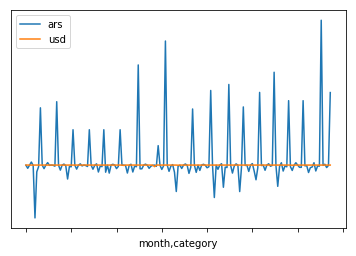

In [16]:
df['month'] = df['date'].apply(lambda x: x.strftime('%y%m'))
df.groupby(['month', 'category']).sum().plot(yticks=[]);